In [2]:
import os
print(os.getcwd())


c:\Users\Admin\Desktop\ML PROJECTS\House Price Prediction\notebooks


In [3]:
import pandas as pd
import numpy as np

In [4]:
import os
print(os.getcwd())

c:\Users\Admin\Desktop\ML PROJECTS\House Price Prediction\notebooks


In [5]:
import os
os.chdir("..")   # move up one level from notebooks to project root
print(os.getcwd())

c:\Users\Admin\Desktop\ML PROJECTS\House Price Prediction


In [6]:
df = pd.read_csv("data/kc_house_data.csv")

In [86]:
# Load the dataset into a pandas DataFrame
import pandas as pd
df = pd.read_csv("data/kc_house_data.csv")

In [89]:

# shape: rows and columns
print("Shape:", df.shape)



Shape: (21613, 21)


In [90]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [91]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [92]:
# missing values count per column
print(df.isna().sum())



id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


In [93]:
# number of exact duplicate rows
print("Duplicate rows:", df.duplicated().sum())


Duplicate rows: 0


In [94]:
# Convert 'date' to datetime
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Convert 'zipcode' to string (categorical)
if 'zipcode' in df.columns:
    df['zipcode'] = df['zipcode'].astype(str)

print(df.dtypes[['date','zipcode']])

date       datetime64[ns]
zipcode            object
dtype: object


In [95]:
import numpy as np

# Bathrooms: clip to a reasonable range (0.5 to 8)
if 'bathrooms' in df.columns:
    df['bathrooms'] = df['bathrooms'].clip(lower=0.5, upper=8)

# Bedrooms: no zero or negative
if 'bedrooms' in df.columns:
    df.loc[df['bedrooms'] <= 0, 'bedrooms'] = df['bedrooms'].median()

# Floors: clip to 1–4
if 'floors' in df.columns:
    df['floors'] = df['floors'].clip(lower=1, upper=4)

# Year built: keep within 1890–2025
if 'yr_built' in df.columns:
    df.loc[(df['yr_built'] < 1890) | (df['yr_built'] > 2025), 'yr_built'] = np.nan
    df['yr_built'] = df['yr_built'].fillna(df['yr_built'].median())

# Year renovated: must not be before year built
if {'yr_built','yr_renovated'}.issubset(df.columns):
    df.loc[df['yr_renovated'] < df['yr_built'], 'yr_renovated'] = 0

# Square footage: no negatives
for col in ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']:
    if col in df.columns:
        df.loc[df[col] < 0, col] = df[col].median()

# Latitude/Longitude: Seattle area bounds
if 'lat' in df.columns:
    df.loc[(df['lat'] < 47.0) | (df['lat'] > 48.0), 'lat'] = df['lat'].median()
if 'long' in df.columns:
    df.loc[(df['long'] < -123.5) | (df['long'] > -121.0), 'long'] = df['long'].median()

print("Sanity checks applied.")

Sanity checks applied.


In [96]:
# Function to clip values outside percentile range
def clip_by_pct(dataframe, col, low_pct=0.01, high_pct=0.99):
    q_low = dataframe[col].quantile(low_pct)
    q_high = dataframe[col].quantile(high_pct)
    dataframe[col] = dataframe[col].clip(q_low, q_high)

# Apply to selected skewed columns
for col in ['sqft_lot','sqft_lot15','sqft_basement','bathrooms']:
    if col in df.columns:
        clip_by_pct(df, col, 0.01, 0.99)

print("Outlier clipping applied.")

Outlier clipping applied.


In [97]:
# Ensure sqft_living is not less than sqft_above
if {'sqft_living','sqft_above'}.issubset(df.columns):
    bad_rows = df['sqft_living'] < df['sqft_above']
    print("Rows where sqft_living < sqft_above:", bad_rows.sum())
    # Drop those rows
    df = df[~bad_rows]

# Ensure sqft_basement is non‑negative
if 'sqft_basement' in df.columns:
    df['sqft_basement'] = df['sqft_basement'].clip(lower=0)

print("Final shape after consistency checks:", df.shape)

Rows where sqft_living < sqft_above: 0
Final shape after consistency checks: (21613, 21)


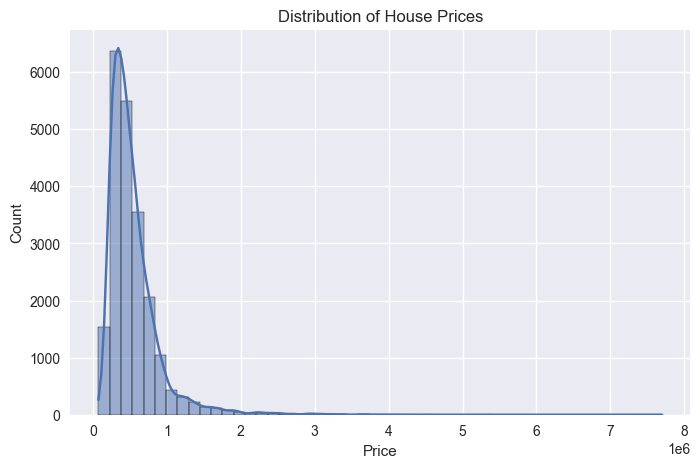

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of house prices
plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

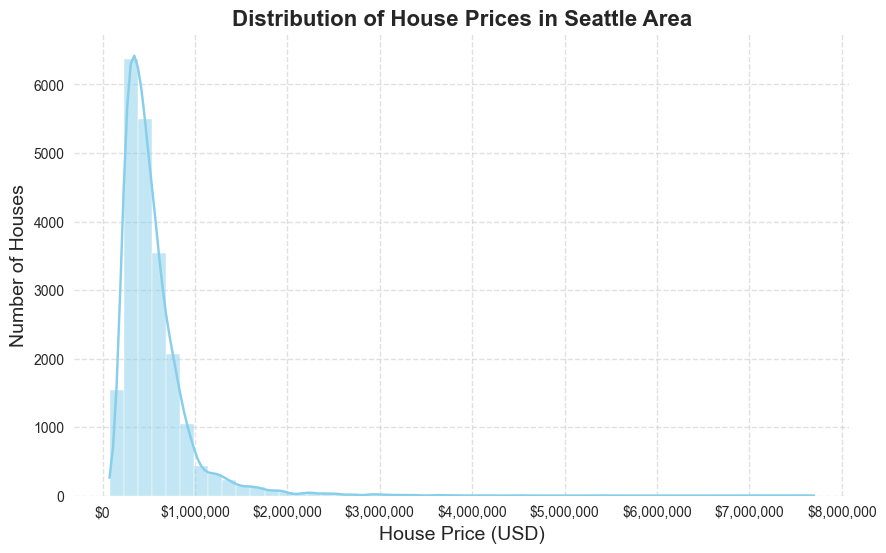

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for readability
sns.set_style("whitegrid")

# Plot histogram with KDE
plt.figure(figsize=(10,6))
sns.histplot(df['price'], bins=50, kde=True, color='skyblue')

# Titles and labels
plt.title("Distribution of House Prices in Seattle Area", fontsize=16, weight='bold')
plt.xlabel("House Price (USD)", fontsize=14)
plt.ylabel("Number of Houses", fontsize=14)

# Format x-axis ticks with commas for readability
plt.gca().get_xaxis().set_major_formatter(
    plt.matplotlib.ticker.FuncFormatter(lambda x, _: f'${x:,.0f}')
)

# Add grid for clarity
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

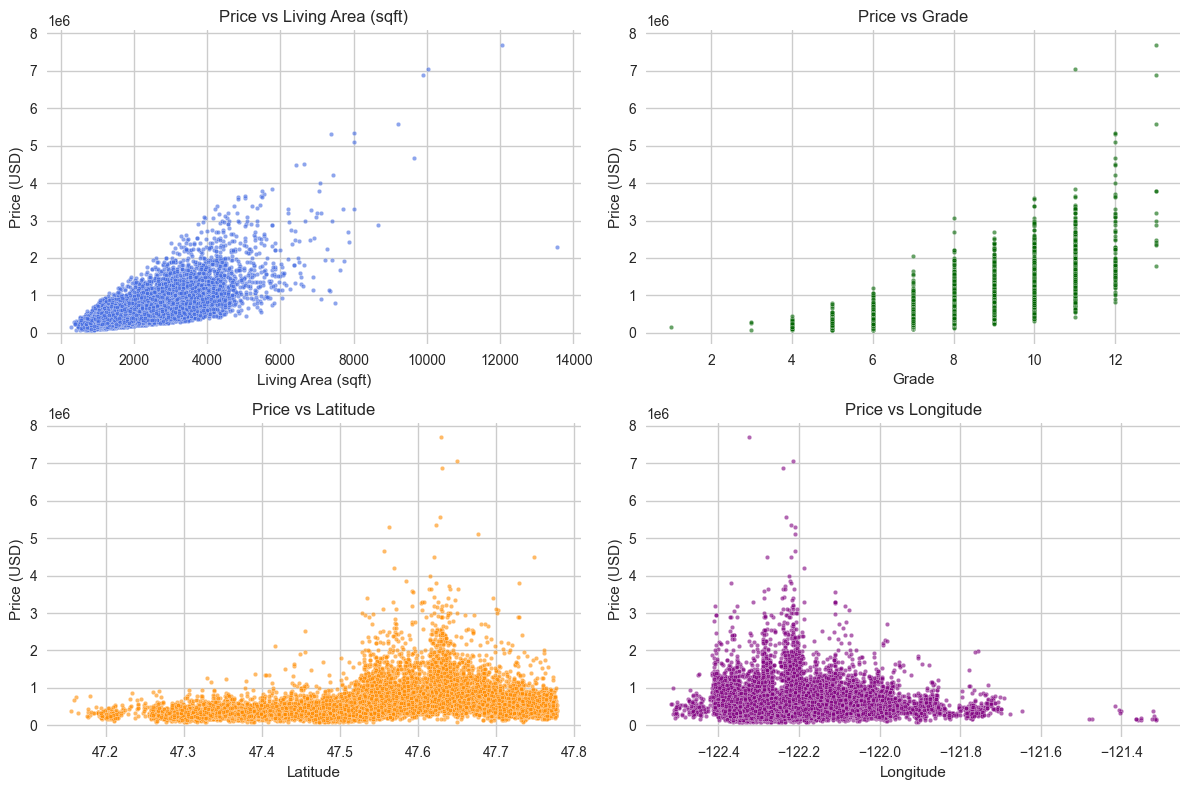

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Create 2x2 grid of scatterplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# sqft_living vs price
sns.scatterplot(x='sqft_living', y='price', data=df, ax=axes[0,0], s=10, alpha=0.6, color='royalblue')
axes[0,0].set_title("Price vs Living Area (sqft)")
axes[0,0].set_xlabel("Living Area (sqft)")
axes[0,0].set_ylabel("Price (USD)")

# grade vs price
sns.scatterplot(x='grade', y='price', data=df, ax=axes[0,1], s=10, alpha=0.6, color='darkgreen')
axes[0,1].set_title("Price vs Grade")
axes[0,1].set_xlabel("Grade")
axes[0,1].set_ylabel("Price (USD)")

# latitude vs price
sns.scatterplot(x='lat', y='price', data=df, ax=axes[1,0], s=10, alpha=0.6, color='darkorange')
axes[1,0].set_title("Price vs Latitude")
axes[1,0].set_xlabel("Latitude")
axes[1,0].set_ylabel("Price (USD)")

# longitude vs price
sns.scatterplot(x='long', y='price', data=df, ax=axes[1,1], s=10, alpha=0.6, color='purple')
axes[1,1].set_title("Price vs Longitude")
axes[1,1].set_xlabel("Longitude")
axes[1,1].set_ylabel("Price (USD)")

plt.tight_layout()
plt.show()

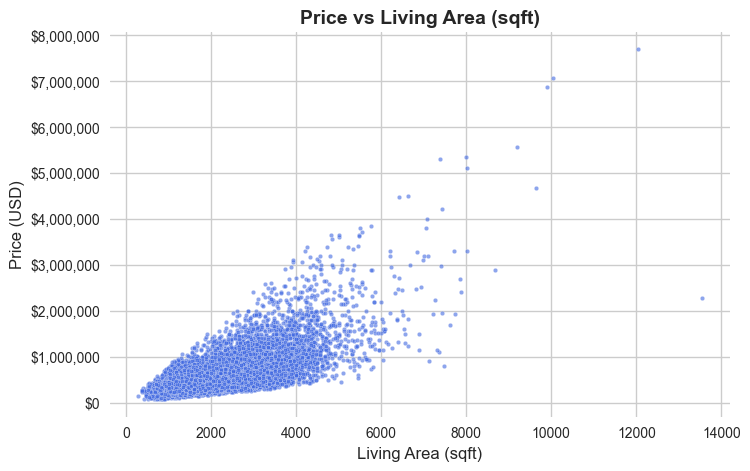

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(8,5))
sns.scatterplot(x='sqft_living', y='price', data=df, s=10, alpha=0.6, color='royalblue')

plt.title("Price vs Living Area (sqft)", fontsize=14, weight='bold')
plt.xlabel("Living Area (sqft)", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)

# Format y-axis with commas and dollar sign
plt.gca().get_yaxis().set_major_formatter(
    plt.matplotlib.ticker.FuncFormatter(lambda y, _: f'${y:,.0f}')
)

plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_11456\1558981830.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bedrooms', y='price', data=df, palette='Set2')


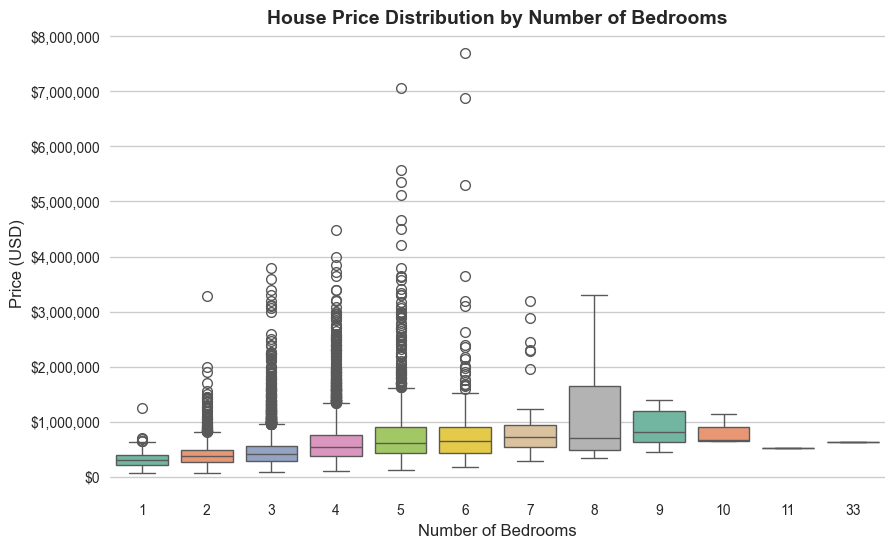

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(10,6))
sns.boxplot(x='bedrooms', y='price', data=df, palette='Set2')

plt.title("House Price Distribution by Number of Bedrooms", fontsize=14, weight='bold')
plt.xlabel("Number of Bedrooms", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)

# Format y-axis with commas and dollar sign
plt.gca().get_yaxis().set_major_formatter(
    plt.matplotlib.ticker.FuncFormatter(lambda y, _: f'${y:,.0f}')
)

plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_11456\2701164001.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bathrooms', y='price', data=df, palette='Set2')


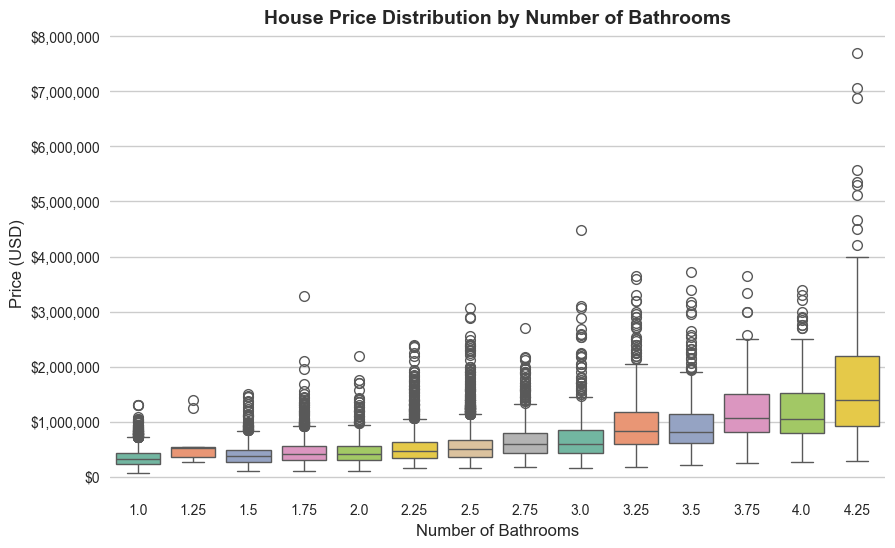

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(10,6))
sns.boxplot(x='bathrooms', y='price', data=df, palette='Set2')

plt.title("House Price Distribution by Number of Bathrooms", fontsize=14, weight='bold')
plt.xlabel("Number of Bathrooms", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)

# Format y-axis with commas and dollar sign
plt.gca().get_yaxis().set_major_formatter(
    plt.matplotlib.ticker.FuncFormatter(lambda y, _: f'${y:,.0f}')
)

plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_11456\4039197363.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='grade', y='price', data=df, palette='Set2')


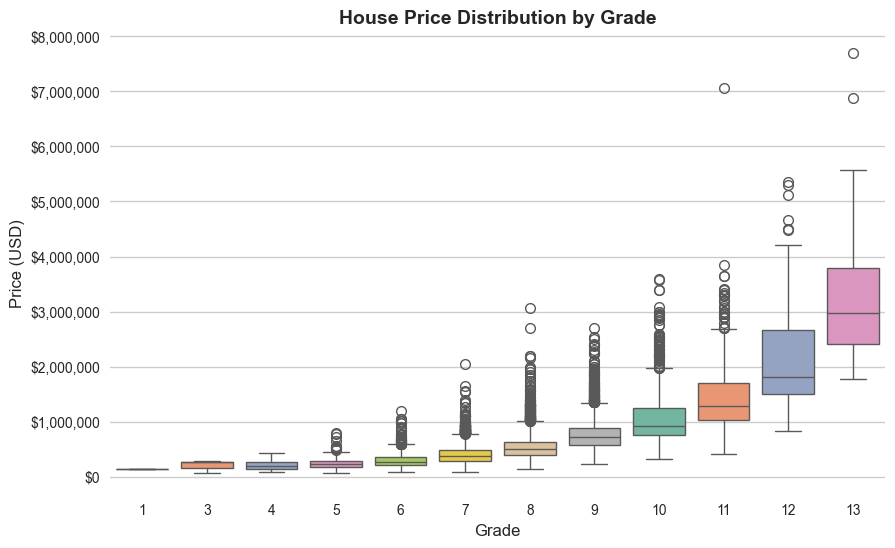

In [105]:
plt.figure(figsize=(10,6))
sns.boxplot(x='grade', y='price', data=df, palette='Set2')
plt.title("House Price Distribution by Grade", fontsize=14, weight='bold')
plt.xlabel("Grade", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.gca().get_yaxis().set_major_formatter(
    plt.matplotlib.ticker.FuncFormatter(lambda y, _: f'${y:,.0f}')
)
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_11456\901775580.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='view', y='price', data=df, palette='Set2')


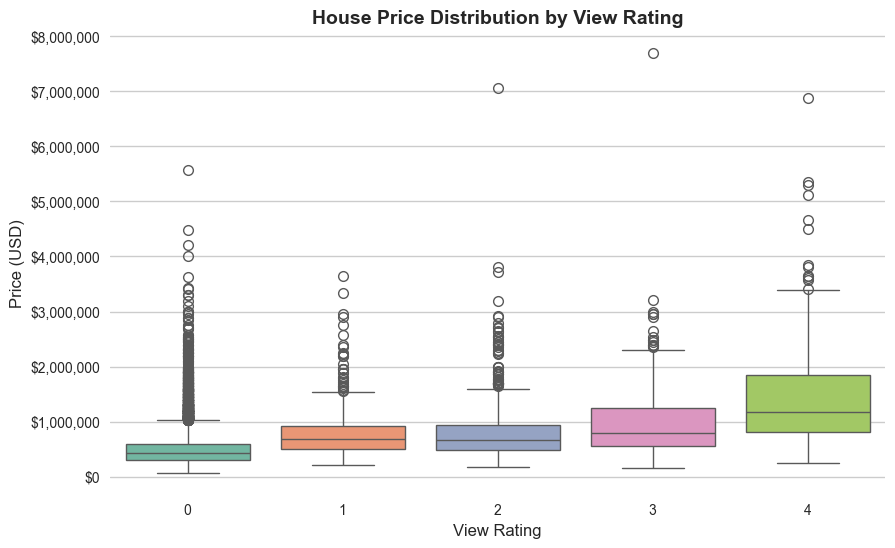

In [106]:
plt.figure(figsize=(10,6))
sns.boxplot(x='view', y='price', data=df, palette='Set2')
plt.title("House Price Distribution by View Rating", fontsize=14, weight='bold')
plt.xlabel("View Rating", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.gca().get_yaxis().set_major_formatter(
    plt.matplotlib.ticker.FuncFormatter(lambda y, _: f'${y:,.0f}')
)
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_11456\909652454.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='waterfront', y='price', data=df, palette='Set2')


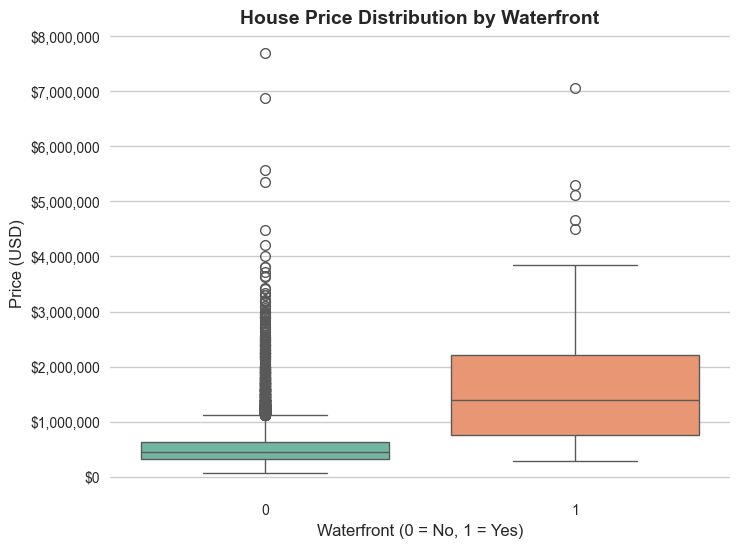

In [107]:
plt.figure(figsize=(8,6))
sns.boxplot(x='waterfront', y='price', data=df, palette='Set2')
plt.title("House Price Distribution by Waterfront", fontsize=14, weight='bold')
plt.xlabel("Waterfront (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.gca().get_yaxis().set_major_formatter(
    plt.matplotlib.ticker.FuncFormatter(lambda y, _: f'${y:,.0f}')
)
plt.show()

In [110]:
from datetime import datetime

# Current year (or you can use df['date'].dt.year.max() for dataset year)
current_year = datetime.now().year
# Create 'house_age' feature
df['house_age'] = current_year - df['yr_built']

In [109]:
# Create 'renovated' binary feature
df['renovated'] = (df['yr_renovated'] > 0).astype(int)


In [111]:
# Create 'has_basement' binary feature
df['has_basement'] = (df['sqft_basement'] > 0).astype(int)

In [112]:
# Create 'living_lot_ratio' feature
df['living_lot_ratio'] = df['sqft_living'] / df['sqft_lot']

In [113]:
# Select engineered features
engineered_features = ['house_age', 'renovated', 'living_lot_ratio', 'has_basement']

# Compute correlations with price
correlations = df[engineered_features + ['price']].corr()['price'].drop('price')
print(correlations)

house_age          -0.054012
renovated           0.126092
living_lot_ratio    0.130073
has_basement        0.180230
Name: price, dtype: float64


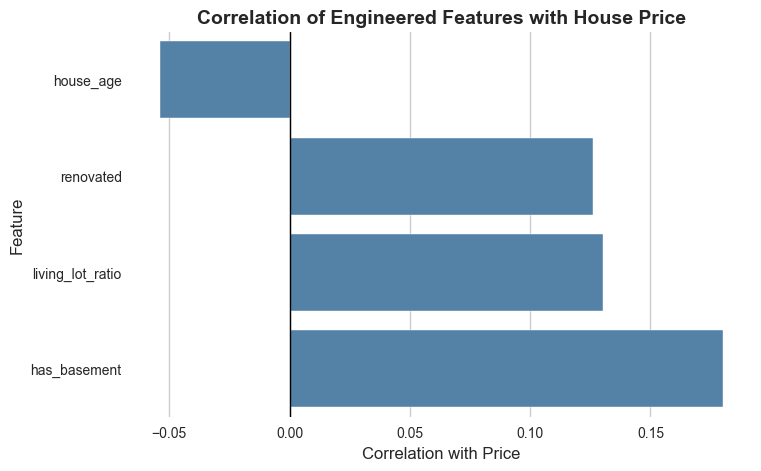

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(x=correlations.values, y=correlations.index, color='steelblue')

plt.title("Correlation of Engineered Features with House Price", fontsize=14, weight='bold')
plt.xlabel("Correlation with Price", fontsize=12)
plt.ylabel("Feature", fontsize=12)

plt.axvline(0, color='black', linewidth=1)
plt.show()

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlations with price
corr_matrix = df.corr(numeric_only=True)
price_corr = corr_matrix['price'].drop('price').sort_values(ascending=False)

# Display top correlations
print(price_corr)

sqft_living         0.702035
grade               0.667434
sqft_above          0.605567
sqft_living15       0.585379
bathrooms           0.504291
view                0.397293
bedrooms            0.308868
lat                 0.307003
sqft_basement       0.302395
waterfront          0.266369
floors              0.256794
has_basement        0.180230
living_lot_ratio    0.130073
yr_renovated        0.126434
renovated           0.126092
sqft_lot            0.107184
sqft_lot15          0.097761
yr_built            0.054012
condition           0.036362
long                0.021626
id                 -0.016762
house_age          -0.054012
Name: price, dtype: float64


C:\Users\Admin\AppData\Local\Temp\ipykernel_11456\4039127520.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_corr.values, y=price_corr.index, palette="viridis")


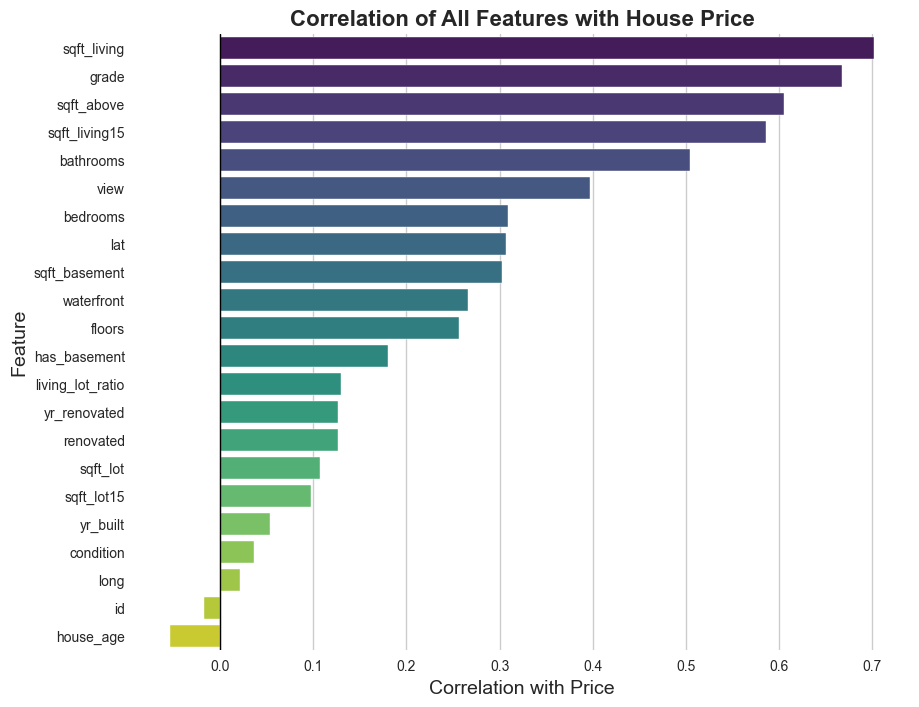

In [116]:
plt.figure(figsize=(10,8))
sns.barplot(x=price_corr.values, y=price_corr.index, palette="viridis")

plt.title("Correlation of All Features with House Price", fontsize=16, weight='bold')
plt.xlabel("Correlation with Price", fontsize=14)
plt.ylabel("Feature", fontsize=14)

# Add vertical line at 0 for reference
plt.axvline(0, color='black', linewidth=1)

plt.show()

In [117]:
# Create a dictionary of new column names
rename_dict = {
    'price': 'House Price (USD)',
    'bedrooms': 'Bedrooms',
    'bathrooms': 'Bathrooms',
    'sqft_living': 'Living Area (sqft)',
    'sqft_lot': 'Lot Size (sqft)',
    'floors': 'Floors',
    'waterfront': 'Waterfront',
    'view': 'View Rating',
    'condition': 'Condition',
    'grade': 'Construction Grade',
    'sqft_above': 'Above Ground Living (sqft)',
    'sqft_basement': 'Basement Area (sqft)',
    'yr_built': 'Year Built',
    'yr_renovated': 'Year Renovated',
    'lat': 'Latitude',
    'long': 'Longitude',
    'sqft_living15': 'Living Area of Neighbors (sqft)',
    'sqft_lot15': 'Lot Size of Neighbors (sqft)',
    'house_age': 'House Age',
    'renovated': 'Renovated (Yes=1)',
    'living_lot_ratio': 'Living-to-Lot Ratio',
    'has_basement': 'Has Basement (Yes=1)'
}

# Apply renaming (only for columns that exist in df)
df = df.rename(columns={k: v for k, v in rename_dict.items() if k in df.columns})

C:\Users\Admin\AppData\Local\Temp\ipykernel_11456\1665288660.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_corr.values, y=price_corr.index, palette="viridis")


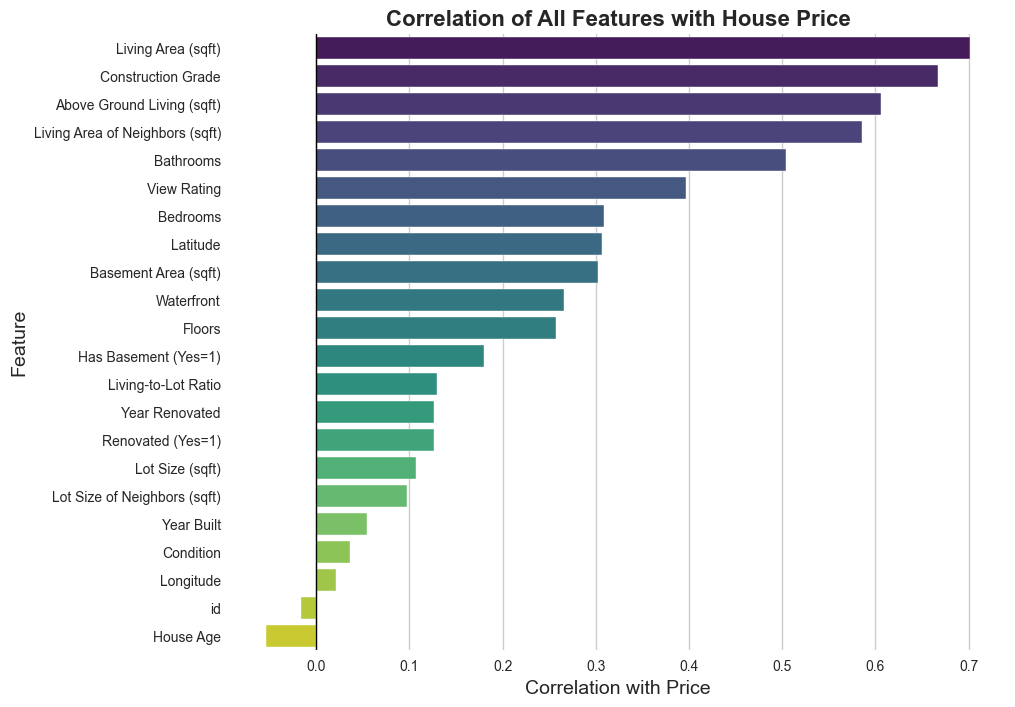

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlations with price
corr_matrix = df.corr(numeric_only=True)
price_corr = corr_matrix['House Price (USD)'].drop('House Price (USD)').sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,8))
sns.barplot(x=price_corr.values, y=price_corr.index, palette="viridis")

plt.title("Correlation of All Features with House Price", fontsize=16, weight='bold')
plt.xlabel("Correlation with Price", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.axvline(0, color='black', linewidth=1)

plt.show()

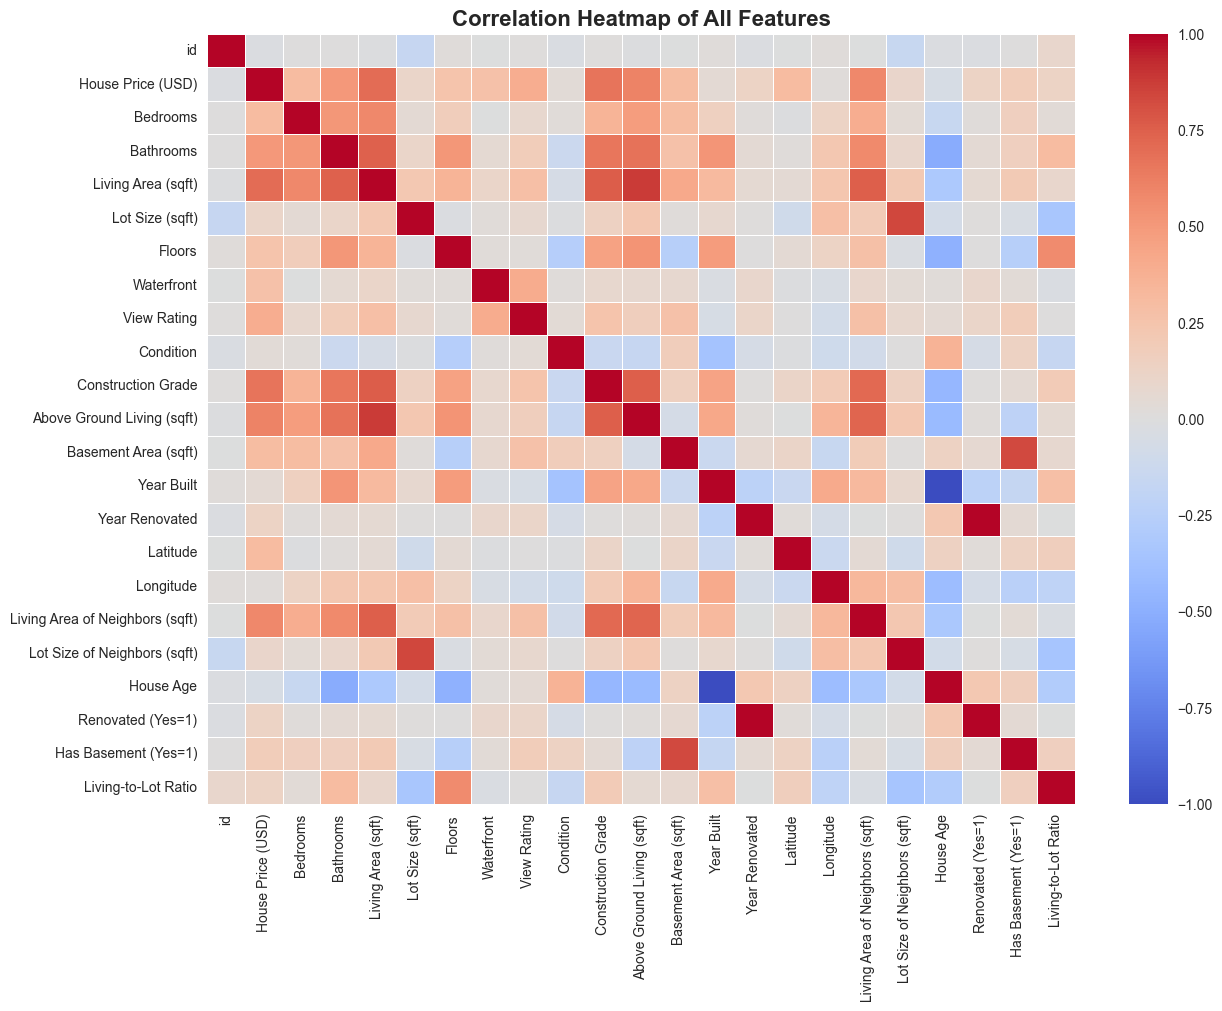

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix for all numeric features
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(14,10))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=False,   # set to True if you want numbers inside cells
    center=0,
    linewidths=0.5
)

plt.title("Correlation Heatmap of All Features", fontsize=16, weight='bold')
plt.show()

In [120]:
from sklearn.model_selection import train_test_split

# Define target and features
y = df['House Price (USD)']
X = df[[
    'Living Area (sqft)',
    'Construction Grade',
    'View Rating',
    'Waterfront',
    'Latitude',
    'Longitude',
    'House Age',
    'Renovated (Yes=1)',
    'Living-to-Lot Ratio',
    'Has Basement (Yes=1)',
    'Bathrooms',
    'Bedrooms'
]]

In [122]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (17290, 12)
Testing set shape: (4323, 12)


In [123]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize and fit model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions
y_pred = lin_reg.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R² Score:", round(r2, 3))
print("RMSE:", round(rmse, 2))

R² Score: 0.691
RMSE: 216132.63


In [124]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize model
rf_model = RandomForestRegressor(
    n_estimators=200,   # number of trees
    max_depth=None,     # let trees expand fully
    random_state=42,
    n_jobs=-1           # use all CPU cores
)

# Fit model
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest R²:", round(r2_rf, 3))
print("Random Forest RMSE:", round(rmse_rf, 2))

Random Forest R²: 0.87
Random Forest RMSE: 139990.14


C:\Users\Admin\AppData\Local\Temp\ipykernel_11456\2717277376.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances, palette="viridis")


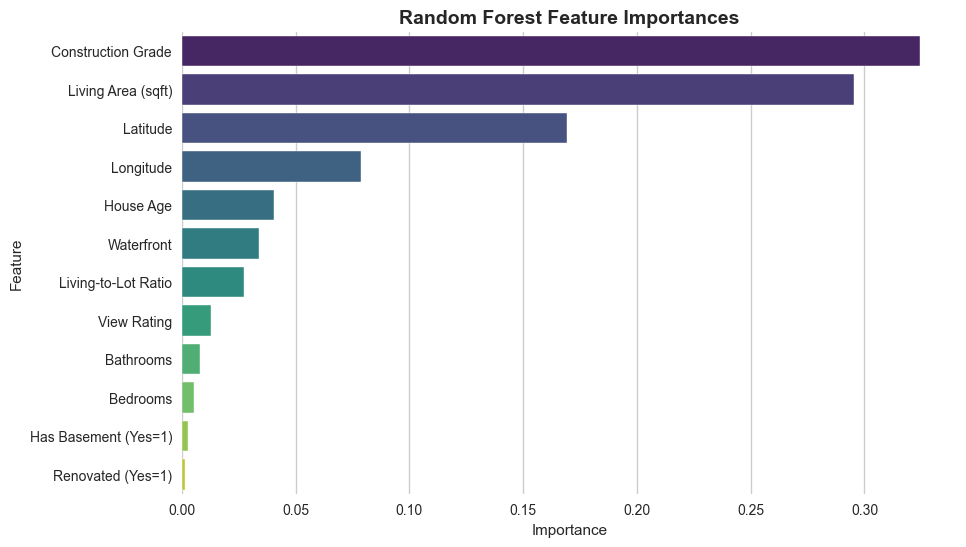

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances, palette="viridis")
plt.title("Random Forest Feature Importances", fontsize=14, weight='bold')
plt.show()

In [127]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("XGBoost R²:", round(r2_xgb, 3))
print("XGBoost RMSE:", round(rmse_xgb, 2))

XGBoost R²: 0.892
XGBoost RMSE: 127752.05


C:\Users\Admin\AppData\Local\Temp\ipykernel_11456\1993161849.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances, palette="viridis")


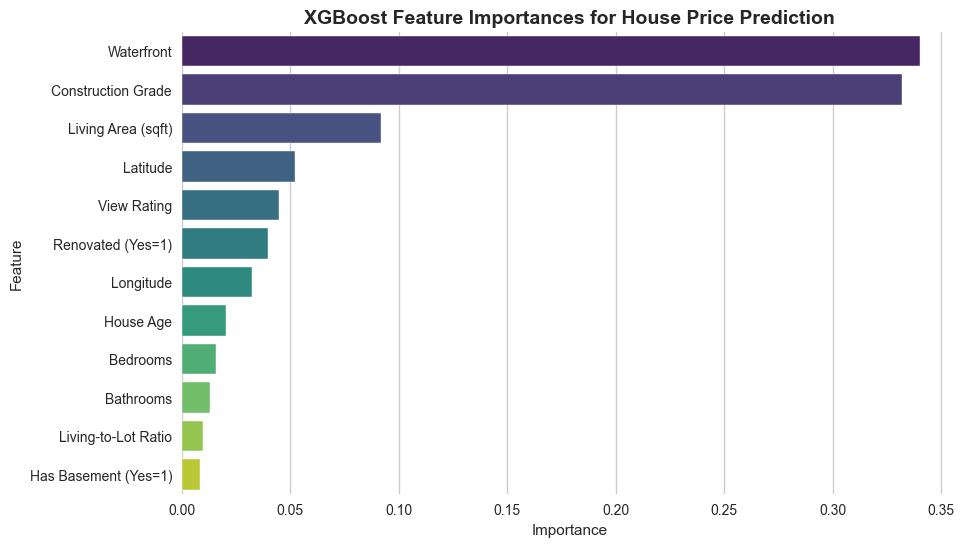

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from tuned XGBoost
best_xgb = xgb_search.best_estimator_
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances, palette="viridis")
plt.title("XGBoost Feature Importances for House Price Prediction", fontsize=14, weight='bold')
plt.show()

In [131]:
import joblib, json

# Save the tuned XGBoost model
joblib.dump(xgb_search.best_estimator_, "xgb_model.pkl")

# Save the feature list
features = list(X_train.columns)
with open("features.json", "w") as f:
    json.dump(features, f)

# Save the rename dictionary (if you used one)
rename_dict = {
    'price': 'House Price (USD)',
    'sqft_living': 'Living Area (sqft)',
    'grade': 'Construction Grade',
    'view': 'View Rating',
    'waterfront': 'Waterfront',
    'lat': 'Latitude',
    'long': 'Longitude',
    'house_age': 'House Age',
    'renovated': 'Renovated (Yes=1)',
    'living_lot_ratio': 'Living-to-Lot Ratio',
    'has_basement': 'Has Basement (Yes=1)',
    'bathrooms': 'Bathrooms',
    'bedrooms': 'Bedrooms'
}
with open("rename_dict.json", "w") as f:
    json.dump(rename_dict, f)

In [132]:
# Load model
model = joblib.load("xgb_model.pkl")

# Load features
with open("features.json", "r") as f:
    features = json.load(f)

# Example: predict on new data
import pandas as pd

new_house = pd.DataFrame([{
    'Living Area (sqft)': 2500,
    'Construction Grade': 8,
    'View Rating': 2,
    'Waterfront': 0,
    'Latitude': 47.6,
    'Longitude': -122.3,
    'House Age': 20,
    'Renovated (Yes=1)': 1,
    'Living-to-Lot Ratio': 0.25,
    'Has Basement (Yes=1)': 1,
    'Bathrooms': 3,
    'Bedrooms': 4
}])

predicted_price = model.predict(new_house)[0]
print(f"Predicted Price: ${predicted_price:,.0f}")

Predicted Price: $885,618


In [133]:
# display the table first 5 rows
df.head()

,id,date,House Price (USD),Bedrooms,Bathrooms,Living Area (sqft),Lot Size (sqft),Floors,Waterfront,View Rating,...,Year Renovated,zipcode,Latitude,Longitude,Living Area of Neighbors (sqft),Lot Size of Neighbors (sqft),House Age,Renovated (Yes=1),Has Basement (Yes=1),Living-to-Lot Ratio
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650.0,1.0,0,0,...,0,98178,47.5112,-122.257,1340,5650.0,70.0,0,0,0.208850
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242.0,2.0,0,0,...,1991,98125,47.7210,-122.319,1690,7639.0,74.0,1,1,0.354874
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000.0,1.0,0,0,...,0,98028,47.7379,-122.233,2720,8062.0,92.0,0,0,0.077000
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000.0,1.0,0,0,...,0,98136,47.5208,-122.393,1360,5000.0,60.0,0,1,0.392000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080.0,1.0,0,0,...,0,98074,47.6168,-122.045,1800,7503.0,38.0,0,0,0.207921
